# CPCS 583 Project Final Submission
Helen Zheng\
2023 Dec 12

## Part 1. Data Exploration

In [1]:
#@title Setup
!pip install torch
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /private/var/folders/pt/5rbd0ld57x7gny9rhwscbx_h0000gn/T/pip-req-build-ip38v_he
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /private/var/folders/pt/5rbd0ld57x7gny9rhwscbx_h0000gn/T/pip-req-build-ip38v_he
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 9068ad70e7c46c807d39747d2a70cba7836ea82d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html


In [1]:
# Import Library
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.datasets as datasets
import torch_scatter
import torch_cluster
import torch_sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
import os
pwd = os.getcwd()

In [271]:
#@title Download Dataset (Movie Lens 100K)
dir1 = pwd + '/MovieLens100K'
movielens = datasets.MovieLens100K(dir1)
movielens[0]

HeteroData(
  movie={ x=[1682, 18] },
  user={ x=[943, 24] },
  (user, rates, movie)={
    edge_index=[2, 80000],
    rating=[80000],
    time=[80000],
    edge_label_index=[2, 20000],
    edge_label=[20000],
  },
  (movie, rated_by, user)={
    edge_index=[2, 80000],
    rating=[80000],
    time=[80000],
  }
)

In [5]:
# Exploratory
movielens_data = movielens[0]
num_nodes = movielens_data.num_nodes
print('Movie has {} nodes'.format(num_nodes))

num_edges = movielens_data.num_edges
print('Movie has {} edges'.format(num_edges))

is_directed = movielens_data.is_directed()
print("graph is directed or not:", is_directed)

# Movie Nodes
movie_nodes = movielens_data['movie']
movie_nodes_num = movielens_data['movie'].x.shape[0]
movie_features = movielens_data['movie'].x.shape[1]
print('Movie dataset has {} movie nodes'.format(movie_nodes_num))
print('Movie dataset has {} movie node features'.format(movie_features))

# User Nodes
user_nodes = movielens_data['user']
user_nodes_nums = movielens_data['user'].x.shape[0]
user_features = movielens_data['user'].x.shape[1]
print('Movie dataset has {} user nodes'.format(user_nodes_nums))
print('Movie dataset has {} user node features'.format(user_features))

# Edges
egdes = movielens_data[('user', 'rates', 'movie')]
undircted_egdes = egdes['edge_index'].shape[1]
print('Movie dataset has {} edges'.format(undircted_egdes))


Movie has 2625 nodes
Movie has 160000 edges
graph is directed or not: False
Movie dataset has 1682 movie nodes
Movie dataset has 18 movie node features
Movie dataset has 943 user nodes
Movie dataset has 24 user node features
Movie dataset has 80000 edges


0.55175

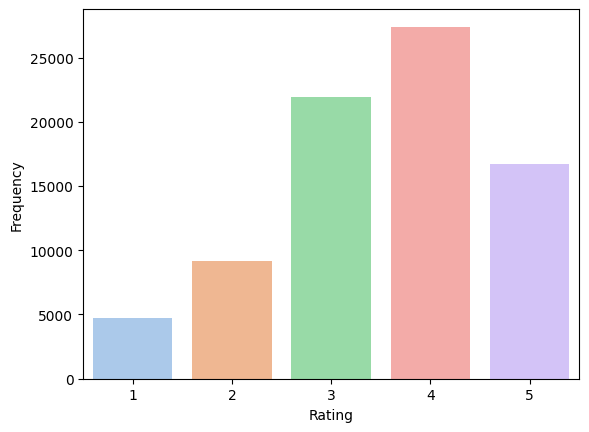

In [ ]:
## Explore Rating
movie_rating = pd.DataFrame(egdes['rating'])

rating = movie_rating.value_counts().sort_index()
color = sns.color_palette("pastel")
fig = sns.barplot(x = [1,2,3,4,5],
            y = rating,
            palette = color[:5],
            )
fig.set(xlabel='Rating', ylabel='Frequency')

(27396+16744)/80000

In [ ]:
np.mean(movie_rating)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    3.52835
dtype: float64

In [ ]:
## Explore Time
movie_time = pd.DataFrame(egdes['time']).astype('float')
pd.to_datetime(movie_time[0], unit = 's')

0       1997-09-22 22:02:38
1       1997-10-15 05:26:11
2       1997-11-03 07:42:40
3       1997-10-15 05:25:19
4       1998-03-13 01:15:12
                ...        
79995   1997-09-29 02:55:56
79996   1998-02-28 04:30:50
79997   1998-02-28 04:30:50
79998   1998-02-28 04:31:15
79999   1998-02-28 19:01:05
Name: 0, Length: 80000, dtype: datetime64[ns]

In [ ]:
movie_rating['User_ID']=egdes['edge_index'][1]
movie_rating['Movie_ID']=egdes['edge_index'][0]

movie_rating.groupby('User_ID').count().reset_index().sort_values(0, ascending = False)[:10]

,User_ID,0,Movie_ID
49,49,484,484
180,180,422,422
257,257,402,402
99,99,395,395
293,293,394,394
287,287,391,391
285,285,388,388
0,0,383,383
120,120,353,353
299,299,352,352


In [ ]:
movie_rating.groupby('User_ID').count().reset_index().sort_values(0, ascending = False)[-5:]

,User_ID,0,Movie_ID
1534,1563,1,1
1535,1565,1,1
1536,1566,1,1
1328,1339,1,1
1649,1681,1,1


In [ ]:
movie_rating.groupby('Movie_ID').count().reset_index().sort_values(0, ascending = False)[:10]

,Movie_ID,0,User_ID
654,654,685,685
404,404,582,582
449,449,494,494
536,536,490,490
415,415,417,417
845,845,405,405
681,681,399,399
12,12,373,373
879,879,368,368
428,428,364,364


In [ ]:
movie_rating.groupby('Movie_ID').count().reset_index().sort_values(0, ascending = False)[-5:]

,Movie_ID,0,User_ID
35,35,9,9
92,92,9,9
257,257,8,8
227,227,7,7
309,309,4,4


In [ ]:
avg_rating_by_user = movie_rating.groupby('User_ID').mean()
avg_rating_by_user

,0,Movie_ID
User_ID,,
0,3.892950,528.626632
1,3.180952,553.819048
2,3.000000,514.893333
3,3.526316,518.695906
4,3.304348,486.637681
...,...,...
1677,1.000000,862.000000
1678,3.000000,862.000000
1679,2.000000,862.000000


In [272]:
#@title Download Dataset (IMDB)
dir2 = pwd+'/IMDB'
imdb = datasets.IMDB(dir2)

In [218]:
# Exploratory
imdb_dataset = imdb[0]
num_nodes = imdb_dataset.num_nodes
print('Movie has {} nodes'.format(num_nodes))

num_edges = imdb_dataset.num_edges
print('Movie has {} edges'.format(num_edges))

is_directed = imdb_dataset.is_directed()
print("graph is directed or not:", is_directed)

# Movie Nodes
movie_nodes = imdb_dataset['movie']
movie_nodes_num = imdb_dataset['movie'].x.shape[0]
movie_features = imdb_dataset['movie'].x.shape[1]
print('Movie dataset has {} movie nodes'.format(movie_nodes_num))
print('Movie dataset has {} movie node features'.format(movie_features))

# Actor Nodes
actor_nodes = imdb_dataset['actor']
actor_nodes_nums = imdb_dataset['actor'].x.shape[0]
actor_features = imdb_dataset['actor'].x.shape[1]
print('Movie dataset has {} actor nodes'.format(actor_nodes_nums))
print('Movie dataset has {} actor node features'.format(actor_features))

# Edges
egdes = imdb_dataset[('movie', 'to', 'actor')]
undircted_egdes = egdes['edge_index'].shape[1]
print('Movie dataset has {} edges'.format(undircted_egdes))

Movie has 11616 nodes
Movie has 34212 edges
graph is directed or not: False
Movie dataset has 4278 movie nodes
Movie dataset has 3066 movie node features
Movie dataset has 5257 actor nodes
Movie dataset has 3066 actor node features
Movie dataset has 12828 edges


[Text(0.5, 0, 'Number of Movies'), Text(0, 0.5, 'Frequency')]

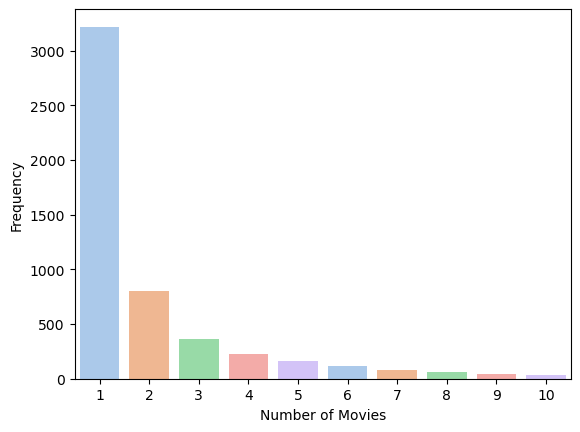

In [252]:
## Visualizations, Actors' Movie Counts
movie_actor = pd.DataFrame()

movie_actor['Actor_ID']= egdes['edge_index'][1]
movie_actor['Movie_ID']=egdes['edge_index'][0]

movie_count_per_actor = movie_actor.groupby('Actor_ID').count().reset_index()
movie_actor_freq = movie_count_per_actor['Movie_ID']
freq = movie_actor_freq.value_counts().sort_index()

color = sns.color_palette("pastel")
fig = sns.barplot(x = freq.index[:10],
                    y = freq.values[:10],
            palette = color[:5])
fig.set(xlabel='Number of Movies', ylabel='Frequency')


## Part 2. Pre-Process Data

### MovieLens

#### Not Randomlized

In [81]:
## Separate Train and test dataset
import numpy as np

rating = movielens_data[('user', 'rates', 'movie')]['rating'].numpy()
user_index = movielens_data[('user', 'rates', 'movie')]['edge_index'][0][rating>=3].numpy()
movie_index = movielens_data[('user', 'rates', 'movie')]['edge_index'][1][rating>=3].numpy()
positive_rating = rating[rating>=3]

# Shuffle the indices
indices = np.arange(positive_rating.shape[0])
np.random.shuffle(indices)

# Split the indices (80% train, 20% test)
train_size = int(0.8 * len(indices))

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data_lens = user_index[train_indices],  movie_index[train_indices], positive_rating[train_indices],
test_data_lens = user_index[test_indices], movie_index[test_indices], positive_rating[test_indices]

In [9]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class MovieLensDataset(Dataset):
    def __init__(self, user_index, movie_index, ratings):
        self.user_index = user_index
        self.movie_index = movie_index
        self.ratings = ratings

    def __len__(self):
        return len(self.user_index)

    def __getitem__(self, idx):
        return self.user_index[idx], self.movie_index[idx], self.ratings[idx]

train_dataset_lens = MovieLensDataset(train_data_lens[0], train_data_lens[1], train_data_lens[2])
train_loader_movielens = DataLoader(train_dataset_lens, batch_size= 124, shuffle = True)

#### Randomized

In [148]:
sampler_10 = RandomSampler(train_data_lens, replacement = True, num_samples = 42304) # We only sample 80% of data at random
train_loader_movielens_10 = DataLoader(train_dataset_lens, batch_size= 124, sampler = sampler_10)

### IMDB

In [96]:
## Separate Train and test dataset
import numpy as np

edges = imdb_dataset[('movie', 'to', 'actor')]['edge_index']
actor_index = edges[1].numpy()
movie_index = edges[0].numpy()
labels = np.ones(edges.shape[1])

# Shuffle the indices
indices = np.arange(edges.shape[1])
np.random.shuffle(indices)

# Split the indices (80% train, 20% test)
train_size = int(0.8 * len(indices))

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data_imdb = actor_index[train_indices],  movie_index[train_indices], labels[train_indices],
test_data_imdb = actor_index[test_indices], movie_index[test_indices], labels[test_indices]

In [97]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class IMDBDataset(Dataset):
    def __init__(self, actor_index, movie_index, labels):
        self.actor_index = actor_index
        self.movie_index = movie_index
        self.labels = labels

    def __len__(self):
        return len(self.actor_index)

    def __getitem__(self, idx):
        return self.actor_index[idx], self.movie_index[idx], self.labels[idx]

train_dataset_imdb = IMDBDataset(train_data_imdb[0], train_data_imdb[1], train_data_imdb[2])
train_loader_IMDB = DataLoader(train_dataset_imdb, batch_size= 124, shuffle = True)

In [149]:
sampler_10 = RandomSampler(train_dataset_imdb, replacement = True, num_samples = 8208) # We only samples 80% of data at random
train_loader_IMDB_10 = DataLoader(train_dataset_lens, batch_size= 124, sampler = sampler_10)

## Part 3. Model Designing

### NGCF (REFERENCE)

* https://medium.com/@pytorch_geometric/link-prediction-on-heterogeneous-graphs-with-pyg-6d5c29677c70
* https://github.com/huangtinglin/NGCF-PyTorch/tree/master/NGCF
* https://github.com/xiangwang1223/neural_graph_collaborative_filtering/blob/master/NGCF/NGCF.py
* https://medium.com/@meuleman.mathias/reproducing-neural-graph-collaborative-filtering-a8982c7d3df6
*  https://medium.com/stanford-cs224w/recommender-systems-with-gnns-in-pyg-d8301178e377

In [13]:
#@title Define NGCF Class
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

class NGCF(MessagePassing):
    def __init__(self, embed_dim, dropout, bias=True, **kwargs):
        super(NGCF, self).__init__(aggr='add', **kwargs)
        
        self.dropout = dropout
        
        self.Linear1 = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.Linear2 = nn.Linear(embed_dim, embed_dim, bias=bias)
        
        self.init_parameters()

    def init_parameters(self):
        nn.init.xavier_uniform_(self.Linear1.weight)
        nn.init.xavier_uniform_(self.Linear2.weight)

    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        D_sqrt = deg.pow(-0.5)
        D_sqrt[D_sqrt == float('inf')] = 0
        norm = D_sqrt[from_] * D_sqrt[to_]

        # Start propagating messages
        out = self.propagate(edge_index, x=(x, x), norm=norm)

        # Perform update after aggregation
        out += self.Linear1(x)
        out = F.dropout(out, self.dropout, self.training)
        return F.leaky_relu(out)

    def message(self, x2, x1, norm):
        return norm.view(-1, 1) * (self.Linear1(x2) + self.Linear2(x2 * x1))

In [263]:
class NGCF_Final(nn.Module):
    def __init__(self, embed_dim, layers, num_users, num_items, dropout=0.1):
        super(NGCF_Final, self).__init__()
        self.embedding = nn.Embedding(num_users + num_items, embed_dim)
        self.convs = nn.ModuleList(NGCF(embed_dim, dropout=dropout) for i in range(layers))
        self.init_parameters()

    def init_parameters(self):
        nn.init.xavier_uniform_(self.embedding.weight, gain=1)

    def forward(self, edge_index):
        emb_prev = self.embedding.weight
        embs = [emb_prev]
        emb = emb_prev
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = (torch.cat(embs, dim=-1))
        return emb_prev, out

    def encode(self, users, items, edge_index):
        emb_prev, out = self(edge_index)
        return (
            out[users],
            out[items],
            emb_prev[users],
            emb_prev[items]
        )

## Part 4. Model Training

### Movie Lens

In [265]:
import torch.optim as optim

# Define Train_Egde_Index
u = torch.LongTensor(train_data_lens[0])
i = torch.LongTensor(train_data_lens[1]) + num_users

train_edge_index_lens = torch.stack((
  torch.cat([u, i]),
  torch.cat([i, u])
)).to(device)

train_edge_index_lens

tensor([[ 697,  520,  549,  ..., 5403, 5795, 5938],
        [6405, 5776, 5493,  ...,   71,  897,  759]])

In [28]:
## Model 0. Based on MSE loss and non-randomized Data
num_users = 943  # Total number of users
num_items = 1682  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 2  # Layer sizes for GCN

modelNGCF_movielens_0 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCF_movielens_0.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_lens0 = []
log_list_epoch_lens0 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCF_movielens_0.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, ratings in train_loader_movielens:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCF_movielens_0.encode(user_indices, item_indices, train_edge_index_lens)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), ratings.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()

        # Backward and optimize
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_lens0.append(round(mse_total_loss/len(train_loader_movielens),4))
    log_list_epoch_lens0.append(log_total_loss/len(train_loader_movielens))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_movielens)}, Log Loss: {log_total_loss/len(train_loader_movielens)}")

Epoch [1/20], MSE Loss: 1.044284887978288, Log Loss: 0.030012795518411964
Epoch [2/20], MSE Loss: 0.6284121698601742, Log Loss: 0.022635885263494363
Epoch [3/20], MSE Loss: 0.5938380477858372, Log Loss: 0.0222088060880503
Epoch [4/20], MSE Loss: 0.571651102508259, Log Loss: 0.022009934200545384
Epoch [5/20], MSE Loss: 0.5585117317753597, Log Loss: 0.022006651630899945
Epoch [6/20], MSE Loss: 0.5398411876423855, Log Loss: 0.0219134801488361
Epoch [7/20], MSE Loss: 0.5249717790432781, Log Loss: 0.02196432745620713
Epoch [8/20], MSE Loss: 0.50631126126305, Log Loss: 0.02200272312906922
Epoch [9/20], MSE Loss: 0.4907415537839751, Log Loss: 0.022117475606064887
Epoch [10/20], MSE Loss: 0.47284897826873723, Log Loss: 0.022207529142289587
Epoch [11/20], MSE Loss: 0.45783327307019916, Log Loss: 0.02232019976653874
Epoch [12/20], MSE Loss: 0.44313744366587743, Log Loss: 0.022390743338042734
Epoch [13/20], MSE Loss: 0.42879884820911307, Log Loss: 0.022537144332844983
Epoch [14/20], MSE Loss: 0.4

In [23]:
## Model 1. Based on total loss and non-randomized Data
num_users = 943  # Total number of users
num_items = 1682  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 2  # Layer sizes for GCN

modelNGCF_movielens_1 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCF_movielens_1.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_lens1 = []
log_list_epoch_lens1 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCF_movielens_1.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, ratings in train_loader_movielens:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCF_movielens_1.encode(user_indices, item_indices, train_edge_index_lens)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), ratings.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()
        total_loss = mse_loss+log_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_lens1.append(round(mse_total_loss/len(train_loader_movielens),4))
    log_list_epoch_lens1.append(log_total_loss/len(train_loader_movielens))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_movielens)}, Log Loss: {log_total_loss/len(train_loader_movielens)}")

Epoch [1/20], MSE Loss: 0.9906321934291294, Log Loss: 0.02863086642701816
Epoch [2/20], MSE Loss: 0.6085524351032892, Log Loss: 0.02206894044766521
Epoch [3/20], MSE Loss: 0.5740583262622216, Log Loss: 0.02169456926176643
Epoch [4/20], MSE Loss: 0.5634794275012451, Log Loss: 0.02161943151744244
Epoch [5/20], MSE Loss: 0.5451648469133176, Log Loss: 0.02160057963790324
Epoch [6/20], MSE Loss: 0.5308792419400092, Log Loss: 0.02161976849917645
Epoch [7/20], MSE Loss: 0.5190055335433478, Log Loss: 0.021713479389316583
Epoch [8/20], MSE Loss: 0.5009860256097914, Log Loss: 0.021766608694363254
Epoch [9/20], MSE Loss: 0.49491166963789446, Log Loss: 0.021928058505337467
Epoch [10/20], MSE Loss: 0.4703110275000543, Log Loss: 0.021955437351899348
Epoch [11/20], MSE Loss: 0.46125819427626474, Log Loss: 0.02206664317368205
Epoch [12/20], MSE Loss: 0.4440006390388453, Log Loss: 0.02214964152917929
Epoch [13/20], MSE Loss: 0.430551036808474, Log Loss: 0.022237740871463782
Epoch [14/20], MSE Loss: 0.4

In [185]:
## Model 2. Based on total loss and randomized Data 80%
num_users = 943  # Total number of users
num_items = 1682  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 2  # Layer sizes for GCN

modelNGCF_movielens_2 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCF_movielens_2.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_lens2 = []
log_list_epoch_lens2 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCF_movielens_2.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, ratings in train_loader_movielens_10:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCF_movielens_2.encode(user_indices, item_indices, train_edge_index_lens)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), ratings.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()
        total_loss = mse_loss+log_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_lens2.append(round(mse_total_loss/len(train_loader_movielens_10),4))
    log_list_epoch_lens2.append(log_total_loss/len(train_loader_movielens_10))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_movielens_10)}, Log Loss: {log_total_loss/len(train_loader_movielens_10)}")

Epoch [1/20], MSE Loss: 0.22770995208591888, Log Loss: 0.02098777866786161
Epoch [2/20], MSE Loss: 0.12316000413276222, Log Loss: 0.019712423543549247
Epoch [3/20], MSE Loss: 0.12146443495157921, Log Loss: 0.019669723808656486
Epoch [4/20], MSE Loss: 0.10213835004884586, Log Loss: 0.019395359070176445
Epoch [5/20], MSE Loss: 0.08922058455469033, Log Loss: 0.01924894388754204
Epoch [6/20], MSE Loss: 0.08211056562889454, Log Loss: 0.019089339222018307
Epoch [7/20], MSE Loss: 0.07380396205515258, Log Loss: 0.018995414632345328
Epoch [8/20], MSE Loss: 0.06558486927955613, Log Loss: 0.018926176955999685
Epoch [9/20], MSE Loss: 0.06046047083364952, Log Loss: 0.01879696991588724
Epoch [10/20], MSE Loss: 0.06344680404933904, Log Loss: 0.018869700776249693
Epoch [11/20], MSE Loss: 0.05661645089769709, Log Loss: 0.018787018671544673
Epoch [12/20], MSE Loss: 0.05494158111386034, Log Loss: 0.018725217684929133
Epoch [13/20], MSE Loss: 0.05046497562601318, Log Loss: 0.01870394787582302
Epoch [14/20

In [202]:
## Model 3. Based on total loss and non-randomized Data + 3 layers
num_users = 943  # Total number of users
num_items = 1682  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 3  # Layer sizes for GCN

modelNGCF_movielens_3 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCF_movielens_3.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_lens3 = []
log_list_epoch_lens3 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCF_movielens_3.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, ratings in train_loader_movielens:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCF_movielens_3.encode(user_indices, item_indices, train_edge_index_lens)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), ratings.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()
        total_loss = mse_loss+log_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_lens3.append(round(mse_total_loss/len(train_loader_movielens),4))
    log_list_epoch_lens3.append(log_total_loss/len(train_loader_movielens))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_movielens)}, Log Loss: {log_total_loss/len(train_loader_movielens)}")

Epoch [1/20], MSE Loss: 4.820128711660238, Log Loss: 0.037523974284182894
Epoch [2/20], MSE Loss: 0.67688230587392, Log Loss: 0.022956702631376946
Epoch [3/20], MSE Loss: 0.6246220584635992, Log Loss: 0.022280418582312955
Epoch [4/20], MSE Loss: 0.5972636752441282, Log Loss: 0.021975772865378326
Epoch [5/20], MSE Loss: 0.5845638744585407, Log Loss: 0.02179424399270107
Epoch [6/20], MSE Loss: 0.5698747799603107, Log Loss: 0.021658530122921116
Epoch [7/20], MSE Loss: 0.5607684084347316, Log Loss: 0.02162250372160235
Epoch [8/20], MSE Loss: 0.5493929179546705, Log Loss: 0.021525473584719786
Epoch [9/20], MSE Loss: 0.5413727846162381, Log Loss: 0.021616626775167028
Epoch [10/20], MSE Loss: 0.5262311840783238, Log Loss: 0.021552773432444074
Epoch [11/20], MSE Loss: 0.5186690441758068, Log Loss: 0.02161457016191661
Epoch [12/20], MSE Loss: 0.5081245841968813, Log Loss: 0.02165311382564365
Epoch [13/20], MSE Loss: 0.4926471459642227, Log Loss: 0.021716246625683347
Epoch [14/20], MSE Loss: 0.4

In [207]:
## Model 4. Based on total loss and non-randomized Data + 4 layers
num_users = 943  # Total number of users
num_items = 1682  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 4  # Layer sizes for GCN

modelNGCF_movielens_4 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCF_movielens_4.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_lens4 = []
log_list_epoch_lens4 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCF_movielens_4.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, ratings in train_loader_movielens:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCF_movielens_4.encode(user_indices, item_indices, train_edge_index_lens)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), ratings.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()
        total_loss = mse_loss+log_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_lens4.append(round(mse_total_loss/len(train_loader_movielens),4))
    log_list_epoch_lens4.append(log_total_loss/len(train_loader_movielens))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_movielens)}, Log Loss: {log_total_loss/len(train_loader_movielens)}")

Epoch [1/20], MSE Loss: 12.319079299860872, Log Loss: 0.04227793823147444
Epoch [2/20], MSE Loss: 0.7508443991808478, Log Loss: 0.0234586346013345
Epoch [3/20], MSE Loss: 0.6491482664047974, Log Loss: 0.022462973379872443
Epoch [4/20], MSE Loss: 0.6151716838257095, Log Loss: 0.022010066051393818
Epoch [5/20], MSE Loss: 0.5944001932892364, Log Loss: 0.021855806076868635
Epoch [6/20], MSE Loss: 0.5826470600637396, Log Loss: 0.02175228608732899
Epoch [7/20], MSE Loss: 0.5716481002209058, Log Loss: 0.021606270236942473
Epoch [8/20], MSE Loss: 0.5638138376856855, Log Loss: 0.02154650122572862
Epoch [9/20], MSE Loss: 0.557303354946735, Log Loss: 0.021448256216716432
Epoch [10/20], MSE Loss: 0.5501878266451788, Log Loss: 0.021417020529997152
Epoch [11/20], MSE Loss: 0.5396246016723489, Log Loss: 0.021361692509760062
Epoch [12/20], MSE Loss: 0.5314825911432575, Log Loss: 0.021377431049908073
Epoch [13/20], MSE Loss: 0.5203124914990097, Log Loss: 0.021355327846922977
Epoch [14/20], MSE Loss: 0.

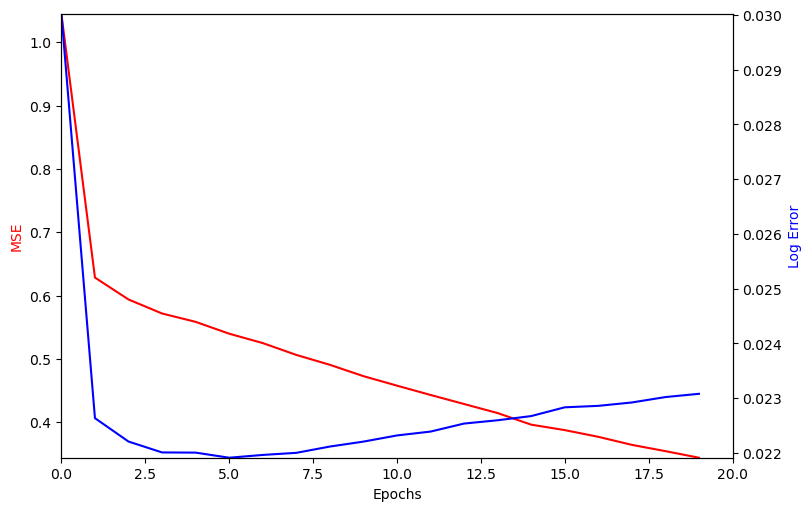

In [253]:
## Visualization
import matplotlib.pyplot as plt
def plot_mse_log(mse_lists, log_lists):
    fig, host = plt.subplots(figsize=(8,5), layout='constrained')
    ax2 = host.twinx()
    host.set_xlim(0, len(mse_lists))
    host.set_ylim(min(mse_lists), max(mse_lists))
    ax2.set_ylim(min(log_lists), max(log_lists))

    host.set_xlabel("Epochs")
    host.set_ylabel("MSE")
    ax2.set_ylabel("Log Error")
    
    host.plot(mse_lists, color= 'red', label= "MSE")
    ax2.plot(log_lists, color = 'blue', label = 'Log Error')
    
    host.yaxis.label.set_color('red')
    ax2.yaxis.label.set_color('blue')

plot_mse_log(mse_list_epoch_lens0, log_list_epoch_lens0)

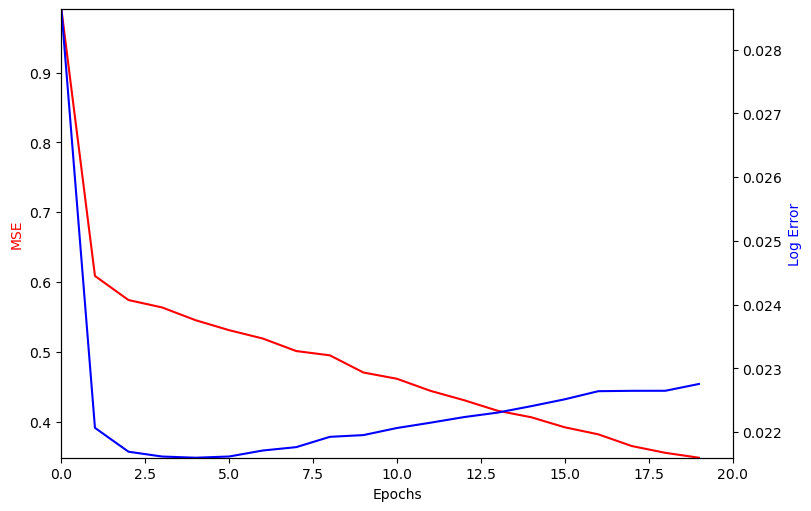

In [254]:
plot_mse_log(mse_list_epoch_lens1, log_list_epoch_lens1)

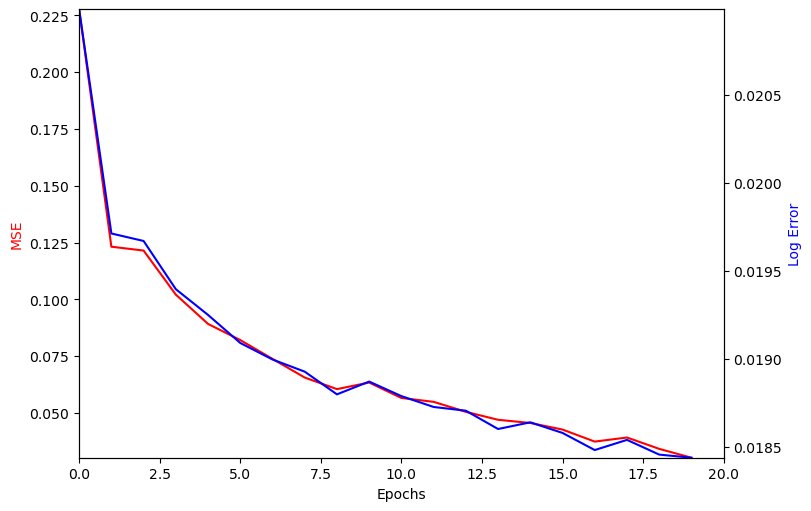

In [255]:
plot_mse_log(mse_list_epoch_lens2, log_list_epoch_lens2)

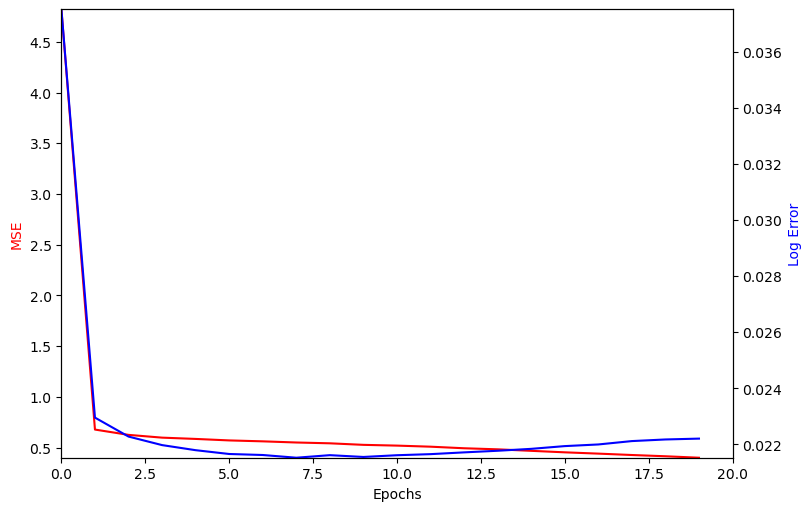

In [256]:
plot_mse_log(mse_list_epoch_lens3, log_list_epoch_lens3)

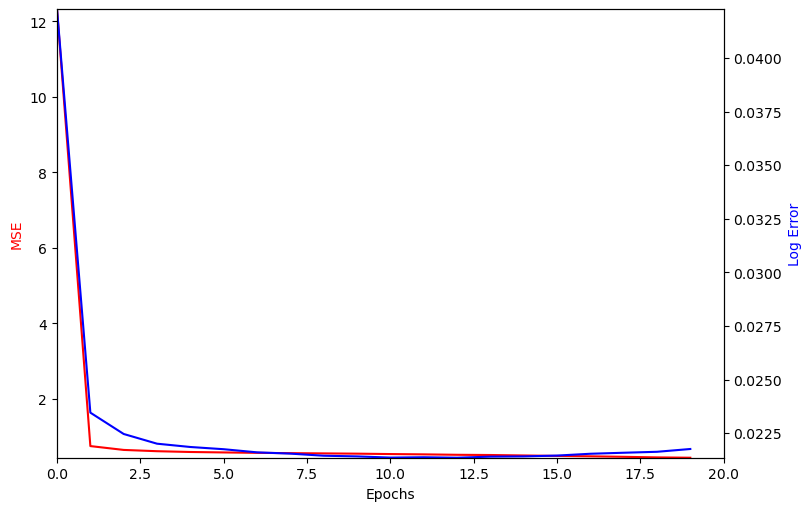

In [257]:
plot_mse_log(mse_list_epoch_lens4, log_list_epoch_lens4)

### IMDB

In [266]:
import torch.optim as optim

u = torch.LongTensor(train_data_imdb[0])
i = torch.LongTensor(train_data_imdb[1]) + num_users

train_edge_index_imdb = torch.stack((
  torch.cat([u, i]),
  torch.cat([i, u])
)).to(device)

train_edge_index_imdb

tensor([[1279,   59, 1595,  ..., 8122, 6306, 6754],
        [8735, 7689, 6727,  ..., 2139, 2472, 1565]])

In [131]:
## Model 0: MSE + Non-ramdom

num_users = 5257  # Total number of users
num_items = 4278  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 2  # Layer sizes for GCN

modelNGCFimdb0 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCFimdb0.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_imdb0 = []
log_list_epoch_imdb0 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCFimdb0.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, labels in train_loader_IMDB:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCFimdb0.encode(user_indices, item_indices, train_edge_index_imdb)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), labels.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()

        # Backward and optimize
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_imdb0.append(round(mse_total_loss/len(train_loader_IMDB),4))
    log_list_epoch_imdb0.append(log_total_loss/len(train_loader_IMDB))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_IMDB)}, Log Loss: {log_total_loss/len(train_loader_IMDB)}")

Epoch [1/20], MSE Loss: 0.5150999433574188, Log Loss: 0.32845722605665045
Epoch [2/20], MSE Loss: 0.03776267736432064, Log Loss: 0.32703488347042037
Epoch [3/20], MSE Loss: 0.019211105071008205, Log Loss: 0.3203970125640731
Epoch [4/20], MSE Loss: 0.014778666658304542, Log Loss: 0.3192787895719689
Epoch [5/20], MSE Loss: 0.012919734153582389, Log Loss: 0.3179596188556717
Epoch [6/20], MSE Loss: 0.011927374548851007, Log Loss: 0.31783260099859123
Epoch [7/20], MSE Loss: 0.010707815037479243, Log Loss: 0.3171402373945857
Epoch [8/20], MSE Loss: 0.009914480632238359, Log Loss: 0.3169819486428456
Epoch [9/20], MSE Loss: 0.009208234509520501, Log Loss: 0.31638730541769283
Epoch [10/20], MSE Loss: 0.008729844236275158, Log Loss: 0.3164543656699629
Epoch [11/20], MSE Loss: 0.00854986745033817, Log Loss: 0.3164432501218405
Epoch [12/20], MSE Loss: 0.008143719695284065, Log Loss: 0.31607567258628017
Epoch [13/20], MSE Loss: 0.008032228477882692, Log Loss: 0.3162634498383625
Epoch [14/20], MSE L

In [132]:
## Model 1: Total Loss + Non-ramdom

num_users = 5257  # Total number of users
num_items = 4278  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 2  # Layer sizes for GCN

modelNGCFimdb1 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCFimdb1.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_imdb1 = []
log_list_epoch_imdb1 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCFimdb1.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, labels in train_loader_IMDB:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCFimdb1.encode(user_indices, item_indices, train_edge_index_imdb)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), labels.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()
        total_loss = mse_loss+log_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_imdb1.append(round(mse_total_loss/len(train_loader_IMDB),4))
    log_list_epoch_imdb1.append(log_total_loss/len(train_loader_IMDB))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_IMDB)}, Log Loss: {log_total_loss/len(train_loader_IMDB)}")

Epoch [1/20], MSE Loss: 0.35001468586634443, Log Loss: 0.3218453010342207
Epoch [2/20], MSE Loss: 0.04959433718797672, Log Loss: 0.29635989306920985
Epoch [3/20], MSE Loss: 0.03208737331162016, Log Loss: 0.2899659706885556
Epoch [4/20], MSE Loss: 0.028841115938252712, Log Loss: 0.28752463768763714
Epoch [5/20], MSE Loss: 0.026913003973573088, Log Loss: 0.28671693406909343
Epoch [6/20], MSE Loss: 0.026101363688168757, Log Loss: 0.28648358834795207
Epoch [7/20], MSE Loss: 0.025213763611503393, Log Loss: 0.2857905629887638
Epoch [8/20], MSE Loss: 0.02463210111551256, Log Loss: 0.28547915241804467
Epoch [9/20], MSE Loss: 0.023992329701242678, Log Loss: 0.2853790162557579
Epoch [10/20], MSE Loss: 0.023308530719165343, Log Loss: 0.28489145780184183
Epoch [11/20], MSE Loss: 0.02278564989297505, Log Loss: 0.28490043655935543
Epoch [12/20], MSE Loss: 0.02278901549078614, Log Loss: 0.2844534063913736
Epoch [13/20], MSE Loss: 0.022044075866151286, Log Loss: 0.28465156311012174
Epoch [14/20], MSE 

In [152]:
## Model 2: Total Loss + Random 80%
num_users = 5257  # Total number of users
num_items = 4278  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 2  # Layer sizes for GCN

modelNGCFimdb2 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCFimdb2.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_imdb2 = []
log_list_epoch_imdb2 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCFimdb2.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, labels in train_loader_IMDB_10:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCFimdb2.encode(user_indices, item_indices, train_edge_index_imdb)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), labels.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()
        total_loss = mse_loss+log_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_imdb2.append(round(mse_total_loss/len(train_loader_IMDB_10),4))
    log_list_epoch_imdb2.append(log_total_loss/len(train_loader_IMDB_10))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_IMDB_10)}, Log Loss: {log_total_loss/len(train_loader_IMDB_10)}")

Epoch [1/20], MSE Loss: 2.5092536593551067, Log Loss: 0.0655272068150008
Epoch [2/20], MSE Loss: 0.7821875018859977, Log Loss: 0.025905668485298086
Epoch [3/20], MSE Loss: 0.6795405176148486, Log Loss: 0.024606494149610178
Epoch [4/20], MSE Loss: 0.6523675522697505, Log Loss: 0.023496925775239718
Epoch [5/20], MSE Loss: 0.6119438436493945, Log Loss: 0.023640251621159156
Epoch [6/20], MSE Loss: 0.6047408478473549, Log Loss: 0.02320518411362349
Epoch [7/20], MSE Loss: 0.5724878093199943, Log Loss: 0.02275128042631185
Epoch [8/20], MSE Loss: 0.5489902202762774, Log Loss: 0.022881565281926697
Epoch [9/20], MSE Loss: 0.5298982209234095, Log Loss: 0.023518330042264356
Epoch [10/20], MSE Loss: 0.5096381382266088, Log Loss: 0.023729204547716612
Epoch [11/20], MSE Loss: 0.49184885798995176, Log Loss: 0.02324167386030973
Epoch [12/20], MSE Loss: 0.47176728052879446, Log Loss: 0.02343353020277486
Epoch [13/20], MSE Loss: 0.44925781372767776, Log Loss: 0.02388100020253836
Epoch [14/20], MSE Loss: 

In [138]:
## Model 3: Total Loss + Non-ramdom + 3 layers
num_users = 5257  # Total number of users
num_items = 4278  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 3  # Layer sizes for GCN

modelNGCFimdb3 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCFimdb3.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_imdb3 = []
log_list_epoch_imdb3 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCFimdb3.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, labels in train_loader_IMDB:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCFimdb3.encode(user_indices, item_indices, train_edge_index_imdb)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), labels.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()
        total_loss = mse_loss+log_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_imdb3.append(round(mse_total_loss/len(train_loader_IMDB),4))
    log_list_epoch_imdb3.append(log_total_loss/len(train_loader_IMDB))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_IMDB)}, Log Loss: {log_total_loss/len(train_loader_IMDB)}")

Epoch [1/20], MSE Loss: 4.240331898342414, Log Loss: 0.2682797889483262
Epoch [2/20], MSE Loss: 0.09997227514185102, Log Loss: 0.3066741278372615
Epoch [3/20], MSE Loss: 0.05823018029332161, Log Loss: 0.2936676033290036
Epoch [4/20], MSE Loss: 0.04262330717440829, Log Loss: 0.2897512995334993
Epoch [5/20], MSE Loss: 0.03587615907371762, Log Loss: 0.28876407175178986
Epoch [6/20], MSE Loss: 0.03217915030398283, Log Loss: 0.2873998489006456
Epoch [7/20], MSE Loss: 0.029709180861891032, Log Loss: 0.28671783783349647
Epoch [8/20], MSE Loss: 0.028065171137631656, Log Loss: 0.2861661490905716
Epoch [9/20], MSE Loss: 0.026830485202820904, Log Loss: 0.2858053715114134
Epoch [10/20], MSE Loss: 0.025902139382010483, Log Loss: 0.2857038034013955
Epoch [11/20], MSE Loss: 0.02511245097561055, Log Loss: 0.2853469101779432
Epoch [12/20], MSE Loss: 0.02468865577984287, Log Loss: 0.2851671490324549
Epoch [13/20], MSE Loss: 0.024092881368046784, Log Loss: 0.28492569025740566
Epoch [14/20], MSE Loss: 0.0

In [264]:
## Model 4: Total Loss + Non-ramdom + 4 layers
num_users = 5257  # Total number of users
num_items = 4278  # Total number of items
emb_dim = 64  # Embedding dimension
layers = 4  # Layer sizes for GCN

modelNGCFimdb4 = NGCF_Final(emb_dim, layers, num_users, num_items)
criterion = nn.MSELoss()  # or nn.BCELoss() for binary data
optimizer = optim.Adam(modelNGCFimdb4.parameters(), lr=0.001)

num_epochs = 20  # Number of training epochs
mse_list_epoch_imdb4 = []
log_list_epoch_imdb4 = []

# Training loop
for epoch in range(num_epochs):
    modelNGCFimdb4.train()
    mse_total_loss = 0
    log_total_loss = 0

    for user_indices, item_indices, labels in train_loader_IMDB:
        # Forward pass
        users_emb, item_emb, _,  _ = modelNGCFimdb4.encode(user_indices, item_indices, train_edge_index_imdb)
        outputs = torch.mul(users_emb, item_emb).sum(dim=1)
        mse_loss = criterion(outputs.float(), labels.float())
        log_loss = -(torch.log(torch.sigmoid(outputs))).mean()
        total_loss = mse_loss+log_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        mse_total_loss += mse_loss.item()
        log_total_loss += log_loss.item()

    mse_list_epoch_imdb4.append(round(mse_total_loss/len(train_loader_IMDB),4))
    log_list_epoch_imdb4.append(log_total_loss/len(train_loader_IMDB))

    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_total_loss/len(train_loader_IMDB)}, Log Loss: {log_total_loss/len(train_loader_IMDB)}")

Epoch [1/20], MSE Loss: 9.915129515600492, Log Loss: 0.21294516379978642
Epoch [2/20], MSE Loss: 0.22868870638580208, Log Loss: 0.31730075880705594
Epoch [3/20], MSE Loss: 0.12569458818579293, Log Loss: 0.3050659420978592
Epoch [4/20], MSE Loss: 0.07928481020302658, Log Loss: 0.29582788283566397
Epoch [5/20], MSE Loss: 0.05923958742115871, Log Loss: 0.29257744694330606
Epoch [6/20], MSE Loss: 0.04870662315333464, Log Loss: 0.29094968969563406
Epoch [7/20], MSE Loss: 0.04119215782238058, Log Loss: 0.28943620783736906
Epoch [8/20], MSE Loss: 0.037864673478775715, Log Loss: 0.28846688407013216
Epoch [9/20], MSE Loss: 0.034670840948820114, Log Loss: 0.28772917748933813
Epoch [10/20], MSE Loss: 0.031621406707598505, Log Loss: 0.2872156105845807
Epoch [11/20], MSE Loss: 0.03095746042588389, Log Loss: 0.2864839693149888
Epoch [12/20], MSE Loss: 0.029211895046643465, Log Loss: 0.2860446331730808
Epoch [13/20], MSE Loss: 0.027902099180472904, Log Loss: 0.28580423758690615
Epoch [14/20], MSE Los

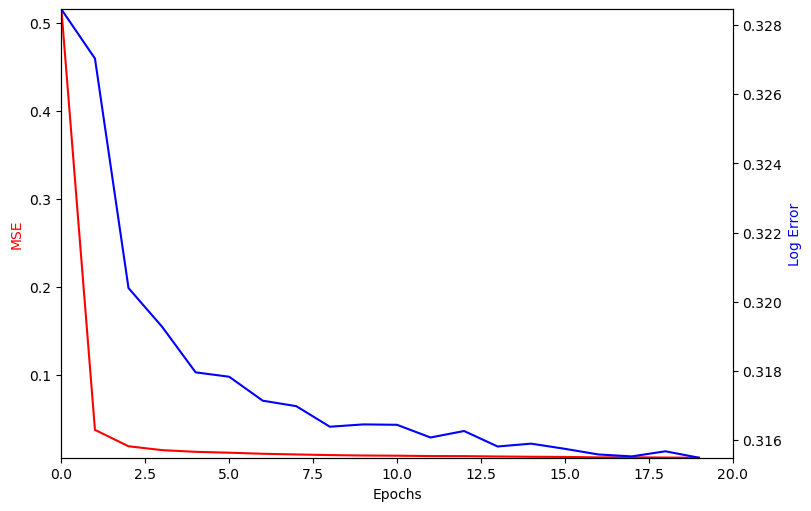

In [258]:
plot_mse_log(mse_list_epoch_imdb0, log_list_epoch_imdb0)

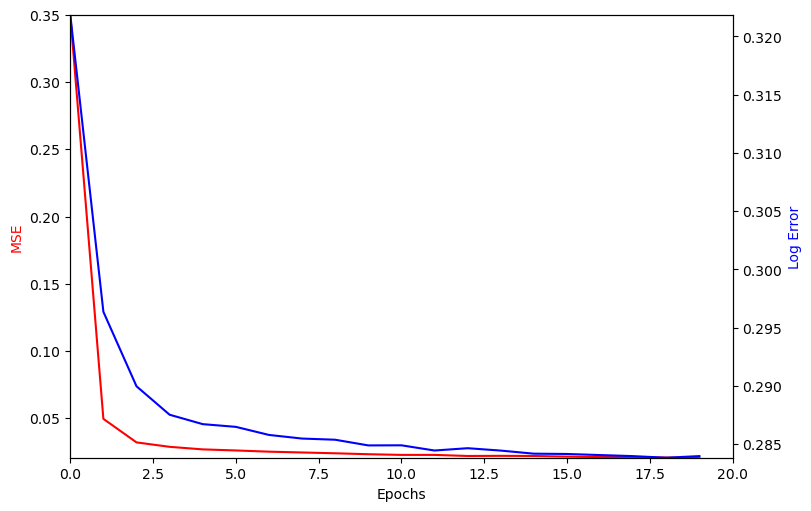

In [259]:
plot_mse_log(mse_list_epoch_imdb1, log_list_epoch_imdb1)

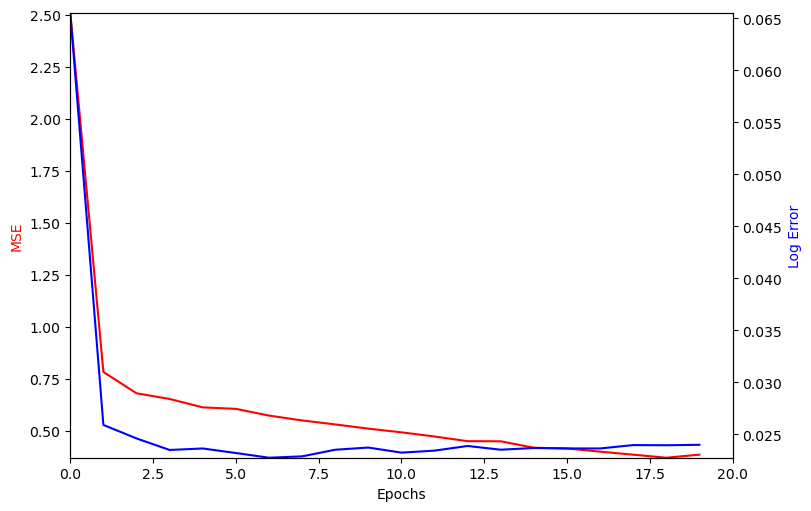

In [260]:
plot_mse_log(mse_list_epoch_imdb2, log_list_epoch_imdb2)

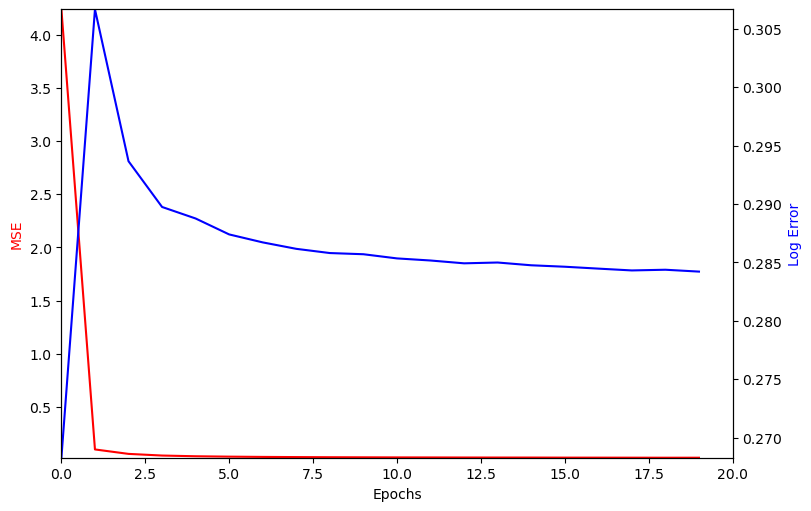

In [262]:
plot_mse_log(mse_list_epoch_imdb3, log_list_epoch_imdb3)

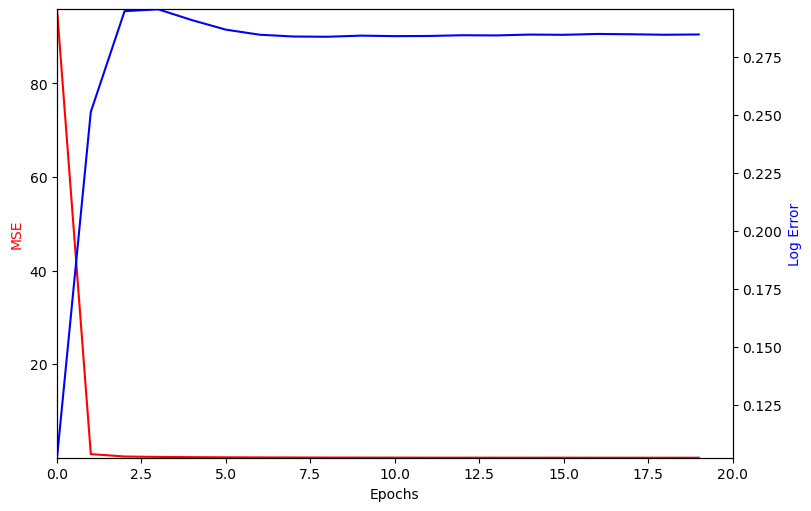

In [261]:
plot_mse_log(mse_list_epoch_imdb4, log_list_epoch_imdb4)

# Part 5. Model Evaluation

### Movie Lens

In [170]:
## Model Evaluation

test_dataset_lens = MovieLensDataset(test_data_lens[0], test_data_lens[1], test_data_lens[2])  # Assuming test_data is prepared
test_sampler_lens = RandomSampler(test_dataset_lens, num_samples = 1240)
test_loader_lens = DataLoader(test_dataset_lens, batch_size=124, sampler = test_sampler_lens)  # Batch size can be adjusted
num_users = 943  # Total number of users
num_items = 1682  # Total number of items

def evaluate_model(model, test_loader, criterion, test_run, num_users, num_items, train_egde_index):
    model.eval()  
    avg_loss_list = []
    
    with torch.no_grad():  
        for i in range(test_run):
            total_loss = 0
            for user_indices, item_indices, ratings in test_loader:
                
                _, out = model(train_egde_index)
                final_user_Embed, final_item_Embed = torch.split(out, (num_users, num_items))
                output = final_user_Embed@torch.transpose(final_item_Embed, 0, 1)
                pred = output[user_indices, item_indices]
                
                loss = criterion(pred.float(), ratings.float())
                total_loss += loss.item()
                
            avg_loss = total_loss / len(test_loader)
            avg_loss_list.append(avg_loss)
            
    return avg_loss_list

In [171]:
criterion = nn.MSELoss() 
test_loss0_lens = evaluate_model(modelNGCF_movielens_0, test_loader_lens, criterion, 10, num_users, num_items, train_edge_index_lens)
print(f"Test Loss: {test_loss0_lens}")

Test Loss: [1.6672998428344727, 1.842763566970825, 1.549820226430893, 1.4717398047447205, 1.7297109246253968, 1.5101947903633117, 1.7145683765411377, 1.7150878429412841, 1.726213848590851, 1.517955207824707]


In [172]:
criterion = nn.MSELoss() 
test_loss1_lens = evaluate_model(modelNGCF_movielens_1, test_loader_lens, criterion, 10, num_users, num_items, train_edge_index_lens)
print(f"Test Loss: {test_loss1_lens}")

Test Loss: [1.2494232177734375, 1.4497269153594972, 1.475381964445114, 1.2873355746269226, 1.4888604581356049, 1.18052134513855, 1.1724390149116517, 1.4107516705989838, 1.2381884932518006, 1.225485360622406]


In [187]:
criterion = nn.MSELoss() 
test_loss2_lens = evaluate_model(modelNGCF_movielens_2, test_loader_lens, criterion, 10, num_users, num_items, train_edge_index_lens)
print(f"Test Loss: {test_loss2_lens}")

Test Loss: [5.619569396972656, 5.482904052734375, 5.397714281082154, 5.486396980285645, 5.544894218444824, 5.227138543128968, 5.611734390258789, 5.583446884155274, 5.5744194984436035, 5.415269804000855]


In [205]:
criterion = nn.MSELoss() 
test_loss3_lens = evaluate_model(modelNGCF_movielens_3, test_loader_lens, criterion, 10, num_users, num_items, train_edge_index_lens)
print(f"Test Loss: {test_loss3_lens}")

Test Loss: [1.1248229801654817, 1.0830177068710327, 1.0988292753696443, 1.096104383468628, 1.110415768623352, 1.0478904247283936, 1.1098858833312988, 1.0724697709083557, 1.1868705749511719, 1.1119633674621583]


In [210]:
criterion = nn.MSELoss() 
test_loss4_lens = evaluate_model(modelNGCF_movielens_4, test_loader_lens, criterion, 10, num_users, num_items, train_edge_index_lens)
print(f"Test Loss: {test_loss4_lens}")

Test Loss: [0.8304283142089843, 0.795781946182251, 0.8060581028461457, 0.8091281354427338, 0.8802952468395233, 0.8040488958358765, 0.8151680648326873, 0.8247247993946075, 0.8286162674427032, 0.8544018149375916]


In [211]:
std0_lens = np.std(test_loss0_lens, dtype = np.float32)
mean0_lens = np.mean(test_loss0_lens, dtype = np.float32)

print(f"Model 0, std: {std0_lens}; Mean: {mean0_lens}")

Model 0, std: 0.11684192717075348; Mean: 1.6445354223251343


In [212]:
std1_lens = np.std(test_loss1_lens, dtype = np.float32)
mean1_lens = np.mean(test_loss1_lens, dtype = np.float32)

print(f"Model 1, std: {std1_lens}; Mean: {mean1_lens}")

Model 1, std: 0.11856524646282196; Mean: 1.317811369895935


In [213]:
std2_lens = np.std(test_loss2_lens, dtype = np.float32)
mean2_lens = np.mean(test_loss2_lens, dtype = np.float32)

print(f"Model 2, std: {std2_lens}; Mean: {mean2_lens}")

Model 2, std: 0.11556446552276611; Mean: 5.494349002838135


In [214]:
std3_lens = np.std(test_loss3_lens, dtype = np.float32)
mean3_lens = np.mean(test_loss3_lens, dtype = np.float32)

print(f"Model 3, std: {std3_lens}; Mean: {mean3_lens}")

Model 3, std: 0.03480173647403717; Mean: 1.104227066040039


In [217]:
std4_lens = np.std(test_loss4_lens, dtype = np.float32)
mean4_lens = np.mean(test_loss4_lens, dtype = np.float32)

print(f"Model 4, std: {std4_lens}; Mean: {mean4_lens}")

Model 4, std: 0.024422306567430496; Mean: 0.8248651623725891


### IMDB

In [188]:
## Model Evaluation

test_dataset_imdb = IMDBDataset(test_data_imdb[0], test_data_imdb[1], test_data_imdb[2])
test_sampler_imdb = RandomSampler(test_dataset_imdb, num_samples = 1240)
test_loader_imdb = DataLoader(test_dataset_imdb, batch_size=124, sampler = test_sampler_imdb) 

num_users = 5257 
num_items = 4278

In [189]:
criterion = nn.MSELoss() 
test_loss0_imdb = evaluate_model(modelNGCFimdb0, test_loader_imdb, criterion, 10, num_users, num_items, train_edge_index_imdb)
print(f"Test Loss: {test_loss0_imdb}")### Movie Lens Data

Test Loss: [0.03884047269821167, 0.037674691528081894, 0.03716768268495798, 0.03772774040699005, 0.03953775577247143, 0.03972603902220726, 0.03974062204360962, 0.03928567580878735, 0.037737407721579075, 0.03862816765904427]


In [190]:
criterion = nn.MSELoss() 
test_loss1_imdb = evaluate_model(modelNGCFimdb1, test_loader_imdb, criterion, 10, num_users, num_items, train_edge_index_imdb)
print(f"Test Loss: {test_loss1_imdb}")### Movie Lens Data

Test Loss: [0.034042243473231794, 0.03346501290798187, 0.034226220846176145, 0.03314858842641115, 0.03352856319397688, 0.03270263932645321, 0.03340212441980839, 0.03388475757092237, 0.03442235998809338, 0.03427987676113844]


In [191]:
criterion = nn.MSELoss() 
test_loss2_imdb = evaluate_model(modelNGCFimdb2, test_loader_imdb, criterion, 10, num_users, num_items, train_edge_index_imdb)
print(f"Test Loss: {test_loss2_imdb}")### Movie Lens Data

Test Loss: [5.12469973564148, 5.167814683914185, 5.132319021224975, 5.096530532836914, 5.177695322036743, 5.119025182723999, 5.129123783111572, 5.133041477203369, 5.1417022228240965, 5.119980049133301]


In [192]:
criterion = nn.MSELoss() 
test_loss3_imdb = evaluate_model(modelNGCFimdb3, test_loader_imdb, criterion, 10, num_users, num_items, train_edge_index_imdb)
print(f"Test Loss: {test_loss3_imdb}")### Movie Lens Data

Test Loss: [0.03231302965432405, 0.030756087973713875, 0.03145610745996237, 0.032832343876361844, 0.031462402641773225, 0.03204908557236195, 0.03142616804689169, 0.03179107680916786, 0.031244946271181108, 0.03265952914953232]


In [193]:
criterion = nn.MSELoss() 
test_loss4_imdb = evaluate_model(modelNGCFimdb4, test_loader_imdb, criterion, 10, num_users, num_items, train_edge_index_imdb)
print(f"Test Loss: {test_loss4_imdb}")### Movie Lens Data

Test Loss: [0.023112956061959268, 0.02424431461840868, 0.024362763576209544, 0.022910838946700096, 0.023933080956339836, 0.02432381045073271, 0.02398747522383928, 0.025341321341693403, 0.02476460821926594, 0.024640517868101598]


In [194]:
std0_imdb = np.std(test_loss0_imdb, dtype = np.float32)
mean0_imdb = np.mean(test_loss0_imdb, dtype = np.float32)

print(f"Model 0, std: {std0_imdb}; Mean: {mean0_imdb}")

Model 0, std: 0.000915932992938906; Mean: 0.03860662132501602


In [196]:
std1_imdb = np.std(test_loss1_imdb, dtype = np.float32)
mean1_imdb = np.mean(test_loss1_imdb, dtype = np.float32)

print(f"Model 1, std: {std1_imdb}; Mean: {mean1_imdb}")

Model 1, std: 0.0005251009133644402; Mean: 0.033710237592458725


In [270]:
std2_imdb = np.std(test_loss2_imdb, dtype = np.float32)
mean2_imdb = np.mean(test_loss2_imdb, dtype = np.float32)

print(f"Model 2, std: {std2_imdb}; Mean: {mean2_imdb}")

Model 2, std: 0.0022473199293017387; Mean: 0.05134192943572998


In [198]:
std3_imdb = np.std(test_loss3_imdb, dtype = np.float32)
mean3_imdb = np.mean(test_loss3_imdb, dtype = np.float32)

print(f"Model 3, std: {std0_imdb}; Mean: {mean0_imdb}")

Model 3, std: 0.000915932992938906; Mean: 0.03860662132501602


In [201]:
std4_imdb = np.std(test_loss4_imdb, dtype = np.float32)
mean4_imdb = np.mean(test_loss4_imdb, dtype = np.float32)

print(f"Model 4, std: {std4_imdb}; Mean: {mean4_imdb}")

Model 4, std: 0.0006931766984052956; Mean: 0.02416216768324375
